In [2]:
from sympy import *
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [5]:
t = symbols('t')
#states
x = Function('x')(t)
y = Function('y')(t)
z = Function('z')(t)
th0 = Function('θ0')(t)
th1 = Function('θ1')(t)
th2 = Function('θ2')(t)

#parameters
R1, R2, R3, R4 = symbols('R1 R2 R3 R4')
m, g = symbols('m g')

#Visuals
    #use clean() to render d/dt as dots and remove the (t) in functions
x_d_disp = Function('\dot{x}')(t)
x_dd_disp = Function('\ddot{x}')(t)
dots = {x.diff(t):x_d_disp, x_d_disp.diff(t):x_dd_disp}
no_t = { 
    x:symbols('x'), 
    x_d_disp:symbols('\dot{x}'), 
    x_dd_disp:symbols('\ddot{x}'), 
}
clean = lambda expr : expr.subs(dots).subs(dots).subs(no_t)
    #keep as fraction rather than floating point
half = Rational(1,2)

# '''Assume no yaw slip first'''

# #Positions 
# x = -sin(th1)*R2
# y = sin(th1)*(R1 + R2*cos(th2)) + L*cos(th1)
# z = cos(th1)*(R1 - R2*cos(th2)) + L*sin(th1)

In [65]:
from util.util import format_transform, rot_xyz_sympy
from numpy import array

#translate then rotate
p = array([0, 0, 0])
R = rot_xyz_sympy('z', th0)
H_yaw = format_transform(R,p) #frame at origin that rotates with base

p = array([0, R1, 0])
R = rot_xyz_sympy('x', th1)
H_roll_rel = format_transform(R,p)
H_roll = H_yaw @ H_roll_rel # frame at joint θ1 that rotates with θ1

p = array([0, 0, R2])
R = rot_xyz_sympy('y', th2)
H_pitch_rel = format_transform(R,p)
H_pitch = H_roll @ H_pitch_rel # frame at joint θ2 that rotates with θ2

p = array([0, R3, 0])
R = eye(3)
H_elbow_rel = format_transform(R,p)
H_elbow = H_pitch @ H_elbow_rel # frame at elbow between joint θ2 and end eff

p = array([0, 0, -R4])
R = eye(3)
H_eff_rel = format_transform(R,p)
H_eff = H_elbow @ H_eff_rel # frame at end eff


H_yaw = Matrix(H_yaw)
H_roll = Matrix(H_roll)
H_pitch = Matrix(H_pitch)
H_elbow = Matrix(H_elbow)
H_eff = Matrix(H_eff)

0

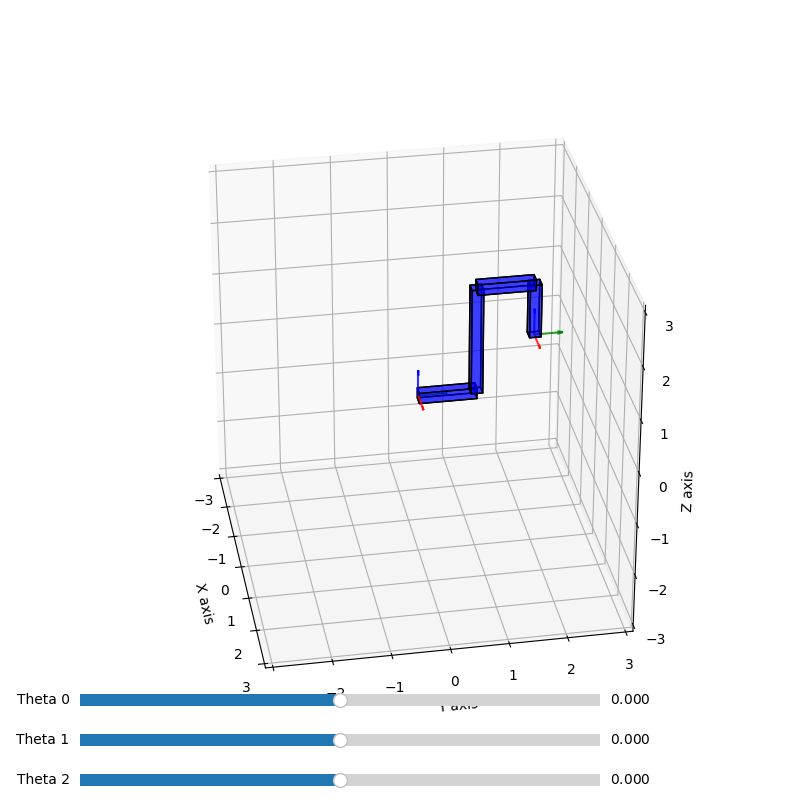

In [82]:
from util.plotcube import *
from util.util import extract_R_p_from_transformation
from matplotlib.widgets import Slider
%matplotlib widget

Rs = {
    R1: 1,
    R2: 2, 
    R3: 1,
    R4: 1 
}

fig, ax = init_3d_plot(cube_lim=3)

axcolor = 'lightgoldenrodyellow'
ax_theta0 = plt.axes([0.1, 0.11, 0.65, 0.03], facecolor=axcolor)
ax_theta1 = plt.axes([0.1, 0.06, 0.65, 0.03], facecolor=axcolor)
ax_theta2 = plt.axes([0.1, 0.01, 0.65, 0.03], facecolor=axcolor)
s_theta0 = Slider(ax_theta0, 'Theta 0', -np.pi, np.pi, valinit=0)
s_theta1 = Slider(ax_theta1, 'Theta 1', -np.pi, np.pi, valinit=0)
s_theta2 = Slider(ax_theta2, 'Theta 2', -np.pi, np.pi, valinit=0)

def update(val=None):
    ax.cla()  # Clear the current axes
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-3, 3])

    ax.view_init(elev=30, azim=-10)  # Set the default view from the y-axis

    thetas = {
        th0: s_theta0.val,
        th1: s_theta1.val,
        th2: s_theta2.val,
    }
    plot_frame(ax, R=eye(3), p=(0,0,0), lengths=0.5)

    R, p = extract_R_p_from_transformation(H_yaw.subs(Rs).subs(thetas))
    plot_link(ax, R, p, size=(0.1, Rs[R1], 0.1), long_ax='y')

    R, p = extract_R_p_from_transformation(H_roll.subs(Rs).subs(thetas))
    plot_link(ax, R, p, size=(0.1, 0.1, Rs[R2]), long_ax='z')

    R, p = extract_R_p_from_transformation(H_pitch.subs(Rs).subs(thetas))
    plot_link(ax, R, p, size=(0.1, Rs[R3], 0.1), long_ax='y')

    R, p = extract_R_p_from_transformation(H_elbow.subs(Rs).subs(thetas))
    plot_link(ax, R, p, size=(0.1, 0.1, -Rs[R4]), long_ax='z')

    R, p = extract_R_p_from_transformation(H_eff.subs(Rs).subs(thetas))
    plot_frame(ax, R, p, lengths=0.5)
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.draw()
update()
s_theta0.on_changed(update)
s_theta1.on_changed(update)
s_theta2.on_changed(update)

(<Figure size 800x800 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

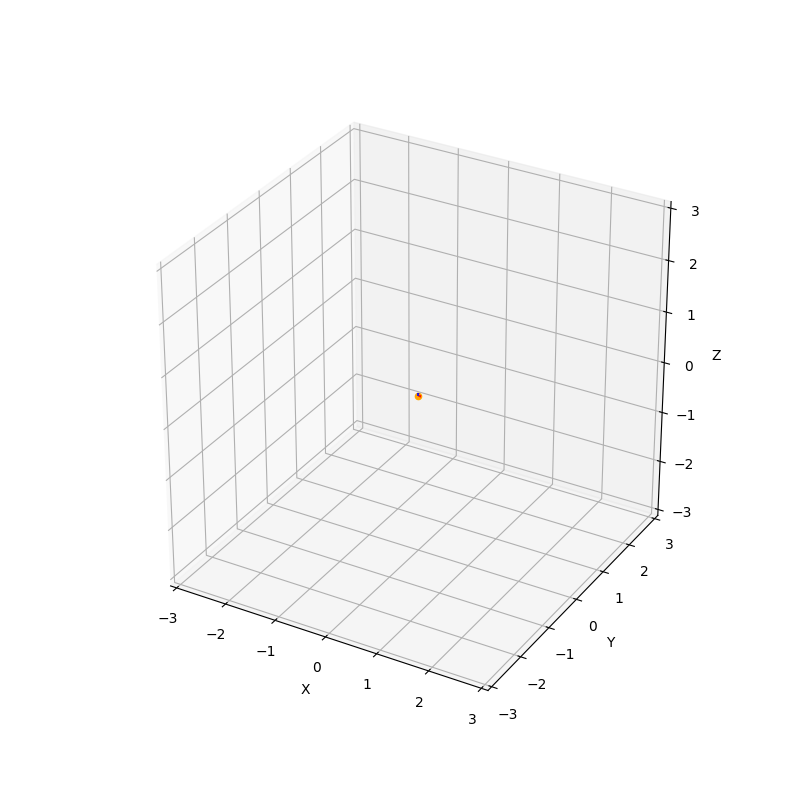

In [40]:
from util.plotcube import *

fig, ax = init_3d_plot(cube_lim=3)
plot_link(ax, )